# Trabalho de Conclusão de Curso - PUC Minas

**Aluno**: Rafael da Silva Rosa (RE: 1223770)

Este trabalho tem como objetivo avaliar os dados de lutas do UFC e validar a performance de alguns Modelos de Machine Learning para avaliar a previsão de qual lutador irá vencer com base a algumas informações da luta.

- **Fontes de dados**: https://www.kaggle.com/rajeevw/ufcdata


- **Scrapping e enriquecimento dos dados dos lutadores**:
    - https://www.tapology.com/fightcenter/fighters/
    - https://www.sherdog.com/fighter/

## Introdução

**O que é (MMA)**: 

    "As artes marciais mistas (MMA) são um esporte de combate de contato que permitem uma ampla variedade de técnicas e habilidades de luta, a partir da mistura de vários outros esportes de combate. As regras permitem o uso de golpes tanto em pé quanto no chão. A arte possibilita que atletas de diferentes origens participem da competição"
    
Além das diferentes estilos de luta existentes, no MMA existem as seguintes formas de vencer:

- **Finalização**: quando o atleta comunica desistência de forma física (usando a mão, dando tapas no chão) ou verbal.
- **Nocaute**: quando o atleta fica inconsciente ou desacordado por causa de golpes ou impacto.
- **Nocaute Técnico**: o árbitro interrompe a luta.
- **Decisão via pontuação, incluindo Unânime**: todos os juízes escolhem o mesmo atleta como vencedor.
- **Dividida**: um juiz escolhe um atleta e os outros dois juízes, o adversário.
- **Majoritária**: dois juízes escolhem o mesmo atleta como vencedor. O terceiro juiz vê empate.
- **Empate**: pode ser unânime, majoritário ou dividido.

**Fonte**: https://www.ufc.com.br/intro-mma

## Arena/Octógono MMA

O Octógono é onde as lutas ocorrem, cara "canto" da arena possui uma cor e são entre vermelho e azul, essa cor determina o espaço de cada lutador para início da luta, intervalos e aplicação de regras.

![octogono](img/octogono.png)

## Golpes MMA

Os golpes comuns no MMA são ilustrados a seguir:

![golpes](img/golpes.png)

Fonte: http://olheirodigital.com.br/site/?p=2656

### Configuração da aplicação

Nesta etapa da aplicação realizei a instalação e a importação das bibliotecas necessárias, seguindo a regra do PEP 8 (https://pep8.org/)

In [1]:
#!pip install xgboost

In [2]:
# -*- coding: utf-8 -*-
    
import matplotlib.pyplot as plt
import math as math
import numpy as np
import pandas as pd
import seaborn as sn

from datetime import datetime
from datetime import date
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics, model_selection, svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

### Funções da aplicação

Aqui agrupei as funções da aplicação, as funções criadas aqui são utilizadas para conversão de padrões americanos para brasileiros, tais como feet para centímetros, lbs para kilogramas etc. Também calculei a idade, quantidade de lutas onde houve ganho ou perda do lutador de cada time.

Calculei a porcentagem e também criei uma função para avaiação dos valores missing de um dataset.

In [3]:
def feet_to_cm(value):
    '''Converte feet para centímetros'''
    
    if value == value:
        value = str(value).replace("'","")
        value = value.replace('"','')
        feet = value.split()[0]
        inches = value.split()[1]
        return round(float(feet) * 30.48 + float(inches) * 2.54,2)

def lbs_to_kg(value):
    '''Converte Lbs para Kg'''
    
    if value == value:
        lbs = value.split()[0]
        return round(float(lbs) * 0.45359237,2)

def inches_to_cm(value):
    '''Converte polegadas para centímetros'''
    
    if value == value:
        #try:
        #print(value)
        inches = str(value).replace('"',"")
        return round(float(inches) * 2.54,2)

def infer_reach(height, reach):
    '''Inferir o reach em branco a partir da altura. 
       Em media, o alcance eh 2% maior que a altura'''
    
    if reach == reach:
        return reach
    else:
        if height == height:
            #print(height)
            #print(reach)
            return round(height * 1.025,2)
        else:
            return None

def calculate_years(birth_date, fight_date):
    '''Calculo da idade'''
    
    if birth_date == birth_date:
        birth_date = datetime.strptime(birth_date, "%b %d, %Y")
        fight_date = datetime.strptime(fight_date, "%B %d, %Y")
        return fight_date.year - birth_date.year - ((fight_date.month, fight_date.day) 
                                                        < (birth_date.month, birth_date.day))
    
def calculate_wins(fight_date, fighter_name):
    '''Calcula a quantidade de vitórias'''
    
    df_filtered = df_combats[(df_combats['date'] < fight_date) 
                              & (df_combats['Winner'] == fighter_name)]
    return len(df_filtered)

def calculate_losses(fight_date, fighter_name):
    '''Calcula a quantidade de derrotas'''
    
    df_filtered = df_combats[(df_combats['date'] < fight_date) 
                             & ((df_combats['R_fighter'] == fighter_name) 
                                    | (df_combats['B_fighter'] == fighter_name)) 
                             & (df_combats['Winner'] != fighter_name)]
    return len(df_filtered)

def calculate_percentage(value):
    '''Calcula a porcentagem'''
        
    v1 = int(value.split()[0])
    v2 = int(value.split()[2])
    if v1 > 0:
        return round(v1/v2,2)
    else:
        return 0
    
def convert_stance(value):
    '''Conversão dos valores categóricos (stance)'''
    
    if value == value:
        value = value.upper()
        
        if value == 'OPEN STANCE':
            return 1
        elif value == 'ORTHODOX':
            return 2
        elif value == 'SWITCH':
            return 3
        elif value == 'SOUTHPAW':
            return 4
        elif value == 'SIDEWAYS':
            return 5
    return None

def convert_fight_endings(value):
    '''Conversão dos valores categóricos (fight_endings)'''
    
    value = value.upper()

    if value == "KO/TKO":
        return 1
    elif value == "TKO - DOCTORS'S STOPPAGE":
        return 2
    elif value == 'DECISION - UNANIMOUS':
        return 3
    elif value == 'SUBMISSION':
        return 4
    elif value == 'DECISION - SPLIT':
        return 5
    elif value == 'COULD NOT CONTINUE':
        return 6
    elif value == 'DECISION - MAJORITY':
        return 7
    elif value == 'DQ':
        return 8
    elif value == 'OTHER':
        return 9
    elif value == 'OVERTURNED':
        return 10
    
def adjust_percentage(value):
    '''Converte a porcentagem (texto) em valor numérico'''
    
    if value == value:
        value = str(value)
        value = int(value.replace('%',''))
        return round(value / 100,2)
    return None

def missing_values(df):
    '''Calcula a quantidade de valores faltantes em um dataframe'''
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing': percent_missing}).round(2)

    missing_value_df.sort_values('percent_missing', inplace=True)
    return missing_value_df

def transform_win_data(x):
    '''Converte o valor categórico para ser encaminhado ao modelo'''
    
    if x['R_fighter'] == x['Winner']: return 0
    else: return 1
    
def model_performance(model,X_test, y_test, y_val_pred):
    '''Apresenta as métricas principais do modelo'''
    
    print("ACURÁCIA:                ",round(metrics.accuracy_score(y_test,y_val_pred),4))  
    print ("PRECISÃO:                ",round(metrics.precision_score(y_test, y_val_pred),4))
    print ("F1-SCORE:                ",round(metrics.f1_score(y_test, y_val_pred),4))
    print ("ERRO QUADRADO AJUSTADO:  ",round(metrics.adjusted_rand_score(y_test, y_val_pred),4))    
    print ("ROC SCORE:               ",round(metrics.roc_auc_score(y_test, y_val_pred),4))  
    print ("MATRIZ DE CONFUSÃO:      \n",metrics.confusion_matrix(y_test, y_val_pred))

### Importação dos datasets

- **scraped_fighter_data.csv**: Dataset criado pelo processo de scrapping que foi documentado em "ufc_fighters_data_scrapper"
- **raw_total_fight_data.csv**: Dataset obtido pelo desafio Kaggle

#### Descrição das variáveis


- R_KD e B_KD = numero de knockdowns que o lutador deu no outro
- Os prefixos R_ e B_ significam estatísticas de lutador de canto vermelho e azul, respectivamente

| Coluna                      | Descrição                                                                                    |
|-|-|
| KD 						  |Número de nocautes                                                                            |
| SIG_STR 					  |Numero de golpes relevantes (golpes encaixados vs. tentativas)                                |
| SIG_STR_pct 				  |Percentual da coluna acima (golpes acertados vs. tentativas)                                  |
| TOTAL_STR 				  |Numero de golpes (relevantes ou não) (golpes acertados vs. tentativas)                        |
| TD 						  |Número de quedas                                                                              |
| TD_pct 					  |Percentual de quedas                                                                          |
| SUB_ATT 					  |Tentativas de submissão                                                                       |
| PASS 						  |Número de vezes que a guarda foi passada (movimento do Jiu Jitsu)                             |
| REV 						  |Número de reversões                                                                           |
| HEAD 						  |Número de golpes relevantes na cabeça (acertados vs. tentativas)                              |
| BODY 						  |Número de golpes relevantes no corpor (acertados vs. tentativas)                              |
| CLINCH 					  |Número de golpes relevantes enquanto estava no clinch (acertados vs. tentativas)              |
| GROUND 					  |Número de golpes relevantes enquanto estava no chão (acertados vs. tentativas)                |
| WIN_BY 					  |Método de vitória                                                                             |
| LAST_ROUND 				  |Último round da luta (exemplo: se foi um nocaute no primeiro round, então o campo será 1)     |
| LAST_ROUND_TIME 			  |Quando a luta foi finalizada no último round                                                  |
| FORMAT 					  |Formato da luta (3 rounds, 5 rounds, etc)                                                     |
| REFEREE 					  |Nome do juiz                                                                                  |
| DATE 						  |Data da luta                                                                                  |
| LOCATION 					  |Localidade da luta                                                                            |
| FIGHT_TYPE 				  |Qual a categoria e se é uma disputa de título ou não                                          |
| WINNER 					  |Vencedor da luta                                                                              |
| STANCE 					  |Posição de luta (ortodoxo (destro), pata  do sul (canhoto), etc)                              |
| HEIGHT_CMS 				  |Altura em centimetros                                                                         |
| REACH_CMS 				  |Alcance do lutador em centímetros                                                             |
| WEIGHT_LBS 				  |Peso do lutador em libras                                                                     |
| AGE 						  |Idade do lutador                                                                              |
| TITLE_BOUT 				  |Booleano que indica se é uma disputa de título ou não                                         |
| WEIGHT_CLASS 				  |Categoria do lutador (peso galo, peso pesado, peso mosca feminino, etc)                       |
| NO_OF_ROUNDS 				  |Número de rounds previsto para a luta                                                         |
| CURRENT_LOSE_STREAK 		  |Número de derrotas seguidas do lutador                                                        |
| CURRENT_WIN_STREAK 		  |Número de vitórias seguidas do lutador                                                        |
| DRAW 						  |Número de empates na carreira do lutador no UFC                                               |
| WINS 						  |Número de vitórias na carreira do lutador no UFC                                              |
| LOSSES 					  |Número de derrotas na carreira do lutador no UFC                                              |
| TOTAL_ROUNDS_FOUGHT 		  |Total de rounds disputados pelo lutador                                                       |
| TOTAL_TIME_FOUGHT 		  |Tempo total lutando em segundos                                                               |
| TOTAL_TITLE_BOUTS 		  |Total de disputas por título que o lutador disputou                                           |
| WIN_BY_DECISION_MAJORITY 	  |Total de vitórias por decisão da maioria dos juízes no UFC                                    |
| WIN_BY_DECISION_SPLIT 	  |Total de vitórias por decisão dividida dos juízes no UFC                                      |
| WIN_BY_DECISION_UNANIMOUS   |Total de vitórias por decisão unânima dos juízes no UFC                                       |
| WIN_BY_KO/TKO 			  |Número de vitórias por nocaute                                                                |
| WIN_BY_SUBMISSION 		  |Número de vitórias por submissão                                                              |
| WIN_BY_TKO_DOCTOR_STOPPAGE  |Número de vitórias por decisão do médico                                                      |

### Importação do dataset

Realizei a importação de ambos dataset, o obtido no Kaggle e o obtidos via Scrapper.

In [4]:
df_fighters = pd.read_csv('data/scraped_fighter_data.csv')
df_combats = pd.read_csv('data/raw_total_fight_data.csv', delimiter=";")

In [5]:
df_combats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   R_fighter        5144 non-null   object
 1   B_fighter        5144 non-null   object
 2   R_KD             5144 non-null   int64 
 3   B_KD             5144 non-null   int64 
 4   R_SIG_STR.       5144 non-null   object
 5   B_SIG_STR.       5144 non-null   object
 6   R_SIG_STR_pct    5144 non-null   object
 7   B_SIG_STR_pct    5144 non-null   object
 8   R_TOTAL_STR.     5144 non-null   object
 9   B_TOTAL_STR.     5144 non-null   object
 10  R_TD             5144 non-null   object
 11  B_TD             5144 non-null   object
 12  R_TD_pct         5144 non-null   object
 13  B_TD_pct         5144 non-null   object
 14  R_SUB_ATT        5144 non-null   int64 
 15  B_SUB_ATT        5144 non-null   int64 
 16  R_PASS           5144 non-null   int64 
 17  B_PASS           5144 non-null   

In [6]:
df_fighters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    3313 non-null   int64 
 1   fighter_name  3313 non-null   object
 2   Height        3214 non-null   object
 3   Weight        3286 non-null   object
 4   Reach         2049 non-null   object
 5   Stance        2439 non-null   object
 6   DOB           2919 non-null   object
dtypes: int64(1), object(6)
memory usage: 181.3+ KB


In [7]:
missing_values(df_combats)

,column_name,percent_missing
R_fighter,R_fighter,0.00
R_BODY,R_BODY,0.00
B_BODY,B_BODY,0.00
R_LEG,R_LEG,0.00
B_LEG,B_LEG,0.00
R_DISTANCE,R_DISTANCE,0.00
B_DISTANCE,B_DISTANCE,0.00
R_CLINCH,R_CLINCH,0.00
B_HEAD,B_HEAD,0.00
B_CLINCH,B_CLINCH,0.00


In [8]:
missing_values(df_fighters)

,column_name,percent_missing
Unnamed: 0,Unnamed: 0,0.00
fighter_name,fighter_name,0.00
Weight,Weight,0.81
Height,Height,2.99
DOB,DOB,11.89
Stance,Stance,26.38
Reach,Reach,38.15


### Tratamento dos dados

Nesta etapa, realizei a padronização dos dados para os volumes no padrão brasileiro.

In [9]:
################# Normalização dos dados #################
df_fighters['Height'] = df_fighters['Height'].apply(feet_to_cm)
df_fighters['Weight'] = df_fighters['Weight'].apply(lbs_to_kg)
df_fighters['Reach']  =  df_fighters['Reach'].apply(inches_to_cm)

Inferi o alcance em branco a partir da altura. Em media, o alcance eh 2% maior que a altura.

In [10]:
# Inferir o reach em branco a partir da altura. 
df_fighters['Reach'] = df_fighters.apply(lambda row: infer_reach(row['Height'],row['Reach']), axis=1)

Apliquei o merge nos dados unindo a informação obtida no processo de Scrapping ("ufc_fighters_data_scrapper.ipynb")

In [11]:
################# Uniao dos Datasets #################

df_combats = pd.merge(df_combats, df_fighters, left_on='R_fighter', right_on='fighter_name', how='left')

df_combats = df_combats.rename(columns={'Height':'Red_Fighter_Height',
                                        'Weight':'Red_Fighter_Weight',
                                        'Reach':'Red_Fighter_Reach',
                                        'Stance':'Red_Fighter_Stance',
                                        'DOB':'Red_Fighter_DOB'})

df_combats = df_combats.drop('fighter_name', axis=1)

df_combats = pd.merge(df_combats, df_fighters, left_on='B_fighter', right_on='fighter_name', how='left')

df_combats = df_combats.rename(columns={'Height':'Blue_Fighter_Height',
                                        'Weight':'Blue_Fighter_Weight',
                                        'Reach':'Blue_Fighter_Reach',
                                        'Stance':'Blue_Fighter_Stance',
                                        'DOB':'Blue_Fighter_DOB'})

df_combats = df_combats.drop('fighter_name', axis=1)

Nesta etapa realizei alguns ajustes necessários, tais como cálculo da idade com base na data de aniversário e data da lura, conversão de tipo e limpeza dos campos temporários

In [12]:
################# Calcular idade #################

df_combats['Red_Fighter_Age'] = df_combats.apply(lambda row: calculate_years(row['Red_Fighter_DOB'], row['date']), axis=1)
df_combats['Blue_Fighter_Age'] = df_combats.apply(lambda row: calculate_years(row['Blue_Fighter_DOB'], row['date']), axis=1)

df_combats['Red_Fighter_Age'] = df_combats['Red_Fighter_Age'].astype(pd.Int16Dtype())
df_combats['Blue_Fighter_Age'] = df_combats['Blue_Fighter_Age'].astype(pd.Int16Dtype())

# Apagar colunas que nao serao utilizadas
df_combats.drop(columns=['Red_Fighter_DOB','Blue_Fighter_DOB'], inplace=True)
df_combats.drop(columns=['Unnamed: 0_x','Unnamed: 0_y'], inplace=True)

################# Converter DataType #################
df_combats['date'] = pd.to_datetime(df_combats['date'], format="%B %d, %Y")

Criar uma coluna com o contador de vitorias do lutador B e R. Contar quantas vezes ele apareceu no campo winner nas lutas anteriores a data da luta observada.

In [13]:
################# Calcular número de vitórias / derrotas #################
df_combats['Blue_wins'] = df_combats.apply(lambda row: calculate_wins(row['date'],row['B_fighter']), axis=1)
df_combats['Red_wins'] = df_combats.apply(lambda row: calculate_wins(row['date'],row['R_fighter']), axis=1)

df_combats['Blue_losses'] = df_combats.apply(lambda row: calculate_losses(row['date'],row['B_fighter']), axis=1)
df_combats['Red_losses'] = df_combats.apply(lambda row: calculate_losses(row['date'],row['R_fighter']), axis=1)

################# Apagar colunas que nao serao mais utilizadas #################
df_combats.drop(columns=['last_round','last_round_time','R_TD','B_TD',
                         'R_SIG_STR.','B_SIG_STR.','R_DISTANCE','B_DISTANCE'], inplace=True)

Calculei a porcentagem dos campos a seguir, com essa normalização o dado poderá ser melhor interpretado no modelo.

In [14]:
################# Aplicar porcentagem para os campos #################

df_combats['R_TOTAL_STR.'] = df_combats['R_TOTAL_STR.'].apply(calculate_percentage)
df_combats['B_TOTAL_STR.'] = df_combats['B_TOTAL_STR.'].apply(calculate_percentage)
df_combats['R_HEAD']       = df_combats['R_HEAD'].apply(calculate_percentage)
df_combats['B_HEAD']       = df_combats['B_HEAD'].apply(calculate_percentage)
df_combats['R_BODY']       = df_combats['R_BODY'].apply(calculate_percentage)
df_combats['B_BODY']       = df_combats['B_BODY'].apply(calculate_percentage)
df_combats['R_LEG']        = df_combats['R_LEG'].apply(calculate_percentage)
df_combats['B_LEG']        = df_combats['B_LEG'].apply(calculate_percentage)
df_combats['R_CLINCH']     = df_combats['R_CLINCH'].apply(calculate_percentage)
df_combats['B_CLINCH']     = df_combats['B_CLINCH'].apply(calculate_percentage)
df_combats['R_GROUND']     = df_combats['R_GROUND'].apply(calculate_percentage)
df_combats['B_GROUND']     = df_combats['B_GROUND'].apply(calculate_percentage)

df_combats['R_SIG_STR_pct'] = df_combats['R_SIG_STR_pct'].apply(adjust_percentage)
df_combats['B_SIG_STR_pct'] = df_combats['B_SIG_STR_pct'].apply(adjust_percentage)
df_combats['R_TD_pct']      = df_combats['R_TD_pct'].apply(adjust_percentage)
df_combats['B_TD_pct']      = df_combats['B_TD_pct'].apply(adjust_percentage)

Para processar as informações do modelo foi necessário transformar os valores categóricos em valores Dummies, desta forma neste caso como a quantidade era menor, a seleção dos valores foi feita manualmente para os campos abaixo:

In [15]:
#Aplicar funcao Dummies - Selecao Manual
df_combats['Blue_Fighter_Stance'] = df_combats['Blue_Fighter_Stance'].apply(convert_stance)
df_combats['Red_Fighter_Stance']  = df_combats['Red_Fighter_Stance'].apply(convert_stance)
df_combats['win_by_']             = df_combats['win_by'].apply(convert_fight_endings)

#Converter tipo de dado
df_combats['Blue_Fighter_Stance'] = df_combats['Blue_Fighter_Stance'].astype(pd.Int16Dtype())
df_combats['Red_Fighter_Stance']  = df_combats['Red_Fighter_Stance'].astype(pd.Int16Dtype())
df_combats['win_by_']             = df_combats['win_by_'].astype(pd.Int16Dtype())

# Apaga registro sem informação de vencedor
df_combats.dropna(subset=['Winner'], inplace=True)
df_combats.dropna(subset=['win_by_'], inplace=True)

A estrutura do dataset ao final do pré-processamento se mantém com 4.991 registros e 48 colunas:

In [16]:
df_combats.shape

(4991, 48)

In [17]:
df_combats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4991 entries, 0 to 5143
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   R_fighter            4991 non-null   object        
 1   B_fighter            4991 non-null   object        
 2   R_KD                 4991 non-null   int64         
 3   B_KD                 4991 non-null   int64         
 4   R_SIG_STR_pct        4991 non-null   float64       
 5   B_SIG_STR_pct        4991 non-null   float64       
 6   R_TOTAL_STR.         4991 non-null   float64       
 7   B_TOTAL_STR.         4991 non-null   float64       
 8   R_TD_pct             4991 non-null   float64       
 9   B_TD_pct             4991 non-null   float64       
 10  R_SUB_ATT            4991 non-null   int64         
 11  B_SUB_ATT            4991 non-null   int64         
 12  R_PASS               4991 non-null   int64         
 13  B_PASS               4991 non-nul

## Análise exploratória

Após o processamento dos dados coletados, o próximo passo é seguir para algumas análises exploratórias, esta fase é uma das fases importantes do processo, pois nela será obtido maiores insigths sobre os detalhes das lutas para seguir com a aplicação do modelo de Machine Learning.

### Valores Missing

O primeiro passo é avaliar a porcentagem dos dados faltantes do dataset pré-processado e avaliar qual estratégia deverá ser seguida:

In [18]:
missing_values(df_combats)

,column_name,percent_missing
R_fighter,R_fighter,0.00
R_LEG,R_LEG,0.00
B_LEG,B_LEG,0.00
R_CLINCH,R_CLINCH,0.00
Red_losses,Red_losses,0.00
R_GROUND,R_GROUND,0.00
B_GROUND,B_GROUND,0.00
win_by,win_by,0.00
Format,Format,0.00
date,date,0.00


Como podemos ver na relação acima as informações que representam o maior valor de dados em falta são:

- Informação de Alcance dos golpes (ambos times) em torno de 3%.
- A informação de idade para o time Azul, falta em torno de 1,5%

Os demais dados faltantes representam uma pequena parcela do dataset e são informações físicas dos lutadores.

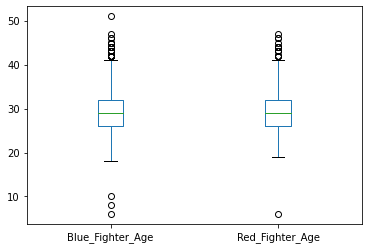

In [19]:
df_combats[['Blue_Fighter_Age','Red_Fighter_Age']].plot.box()

Existiam alguns lutadores onde a informação de idade estava incorreta, essas informações foram apagadas do dataset

In [20]:
df_combats.drop(df_combats[df_combats.Red_Fighter_Age < 18].index, inplace=True)
df_combats.drop(df_combats[df_combats.Blue_Fighter_Age < 18].index, inplace=True)

O gráfico a seguir, apresenta a dispersão dos dados de golpes/tentativas na cabeça e mostra um leve aumento na média de golpes pelo corner vermelho em relação aos golpes do corner adversário.

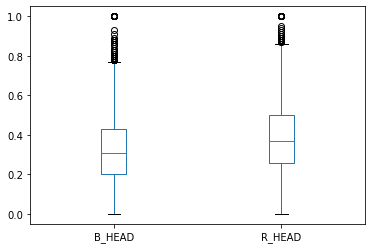

In [21]:
df_combats[['B_HEAD','R_HEAD']].plot.box()

Gerei um BoxPlot também da porcentagem dos golpes dados em uma luta no chão por cada corner, podemos constatar descritivamente que a média de golpes importantes dados quando a luta está no chão para o corner vermelho é 30% maior comparado ao corner azul. 

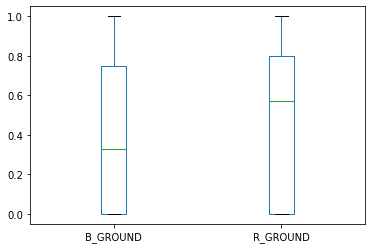

In [22]:
df_combats[['B_GROUND','R_GROUND']].plot.box()

A lista dos **30 principais** lutadores com maior número de vitórias é apresentado a seguir:

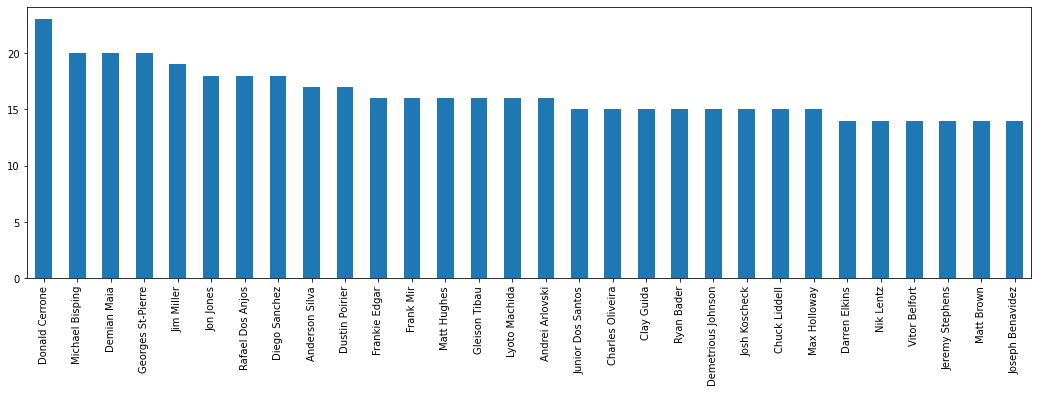

In [23]:
f, ax = plt.subplots(figsize=(18,5))
df_combats.Winner.value_counts().head(30).plot.bar()

In [24]:
print('Red ',round((df_combats[df_combats['R_fighter'] == df_combats['Winner']].shape[0] / df_combats.shape[0]),2))
print('Blue',round((df_combats[df_combats['B_fighter'] == df_combats['Winner']].shape[0] / df_combats.shape[0]),2))

Red  0.68
Blue 0.32


Para aplicação do modelo é necessário realizar a troca dos valores categóricos para valores discretos, sendo assim, os próximos passos são responsáveis por realizar esta tratativa na variável respostas (Winner) onde irá indicar qual o time que ganhou a luta, senso 0 para o corner vermelho e 1 para o azul:

In [25]:
#Tranforma variável resposta em discreta
def set_discret_target(x):
    if x['R_fighter'] == x['Winner']: 
        return 0
    else: 
        return 1

df_combats['Win_Model'] = df_combats.apply(set_discret_target, axis=1)

In [26]:
df_combats[['R_fighter','B_fighter','Win_Model','Winner']].head(10)

,R_fighter,B_fighter,Win_Model,Winner
0,Henry Cejudo,Marlon Moraes,0,Henry Cejudo
1,Valentina Shevchenko,Jessica Eye,0,Valentina Shevchenko
3,Jimmie Rivera,Petr Yan,1,Petr Yan
4,Tai Tuivasa,Blagoy Ivanov,1,Blagoy Ivanov
5,Tatiana Suarez,Nina Ansaroff,0,Tatiana Suarez
6,Aljamain Sterling,Pedro Munhoz,0,Aljamain Sterling
7,Karolina Kowalkiewicz,Alexa Grasso,1,Alexa Grasso
8,Ricardo Lamas,Calvin Kattar,1,Calvin Kattar
9,Yan Xiaonan,Angela Hill,0,Yan Xiaonan
10,Bevon Lewis,Darren Stewart,1,Darren Stewart


A biblioteca **LabelEncoder** foi utilizada para converter as informações categóricas em numéricas, assim o modelo poderá ser aplicádo:

In [27]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df_combats["R_fighter_"] =  lb_make.fit_transform(df_combats["R_fighter"])
df_combats["B_fighter_"] =  lb_make.fit_transform(df_combats["B_fighter"])

df_combats["Referee_"] =    lb_make.fit_transform(df_combats["Referee"].astype(str))
df_combats["location_"] =   lb_make.fit_transform(df_combats["location"])
df_combats["Fight_type_"] = lb_make.fit_transform(df_combats["Fight_type"])
df_combats["Format_"] =     lb_make.fit_transform(df_combats["Format"])

In [28]:
## Transformando variável categorica em dummies

def set_winner_code(x):
    if x['R_fighter'] == x['Winner']: 
        return x['R_fighter_']
    else: 
        return x['B_fighter_']
    
def set_winner_team(x):
    if x['R_fighter'] == x['Winner']: 
        return 'Red Team'
    else: 
        return 'Blue Team'

df_combats['Winner_Code'] = df_combats.apply(set_winner_code, axis=1)
df_combats['Winner_Team'] = df_combats.apply(set_winner_team, axis=1)

Os dados restantes que ficaram faltando são apagados antes da aplicação do modelo, esta decisão foi tomada, pois os dados faltantes não eram significantes.

In [29]:
#Apaga os dados faltantes
df_combats.dropna(inplace=True)

In [30]:
df_combats.shape

(4643, 57)

O número de vitórias do corner vermelho é maior que o corner azul, neste gráfico podemos avaliar, onde o corner azul tem 30% mais vitórias que o corner azul.

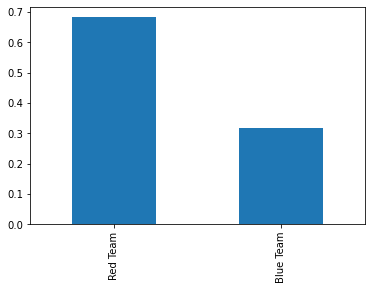

In [31]:
df_combats["Winner_Team"].value_counts(normalize=True).plot.bar()

In [32]:
#Salvar dataset processado
df_combats.to_csv("data/processed_fight_data.csv")

In [33]:
#apagar colunas categóricas
df_combats_ = df_combats.drop([ 'Winner',
                                'win_by',
                                'R_fighter',
                                'B_fighter',
                                'Referee',
                                'location',
                                'Fight_type',
                                'Format',
                                'date',
                                'Winner_Team'],axis=1)

In [34]:
df_combats_.shape

(4643, 47)

### Análise de correlação

Antes de treinar o modelo fiz a validação das variáveis e fui retirando as que tinham maior correlação, para evitar problemas de  de multicolinearidade, que é quando há variáveis que são muito correlacionadas e que podem gerar uma inclinação da correlação de uma forma incorreta. (troca de sinal ou estimativa de parâmetro muito enviesada), o modelo com maior performance foi aplicado com a seguinte configuração do dataset (as colunas comentadas foram testadas, mas com perda de performance após serem retirádas):

In [35]:
#Retirar variáveis mais correlacionadas
df_combats_model = df_combats_
df_combats_model = df_combats_model.drop(columns=['R_TOTAL_STR.','B_TOTAL_STR.',
                                                  'R_SIG_STR_pct','B_SIG_STR_pct',
                                                   'Red_Fighter_Weight','Blue_Fighter_Weight',
                                                   #'Red_Fighter_Height','Blue_Fighter_Height',
                                                   #'Red_wins','Blue_wins',
                                                   #'Red_losses','Blue_losses',
                                           ])

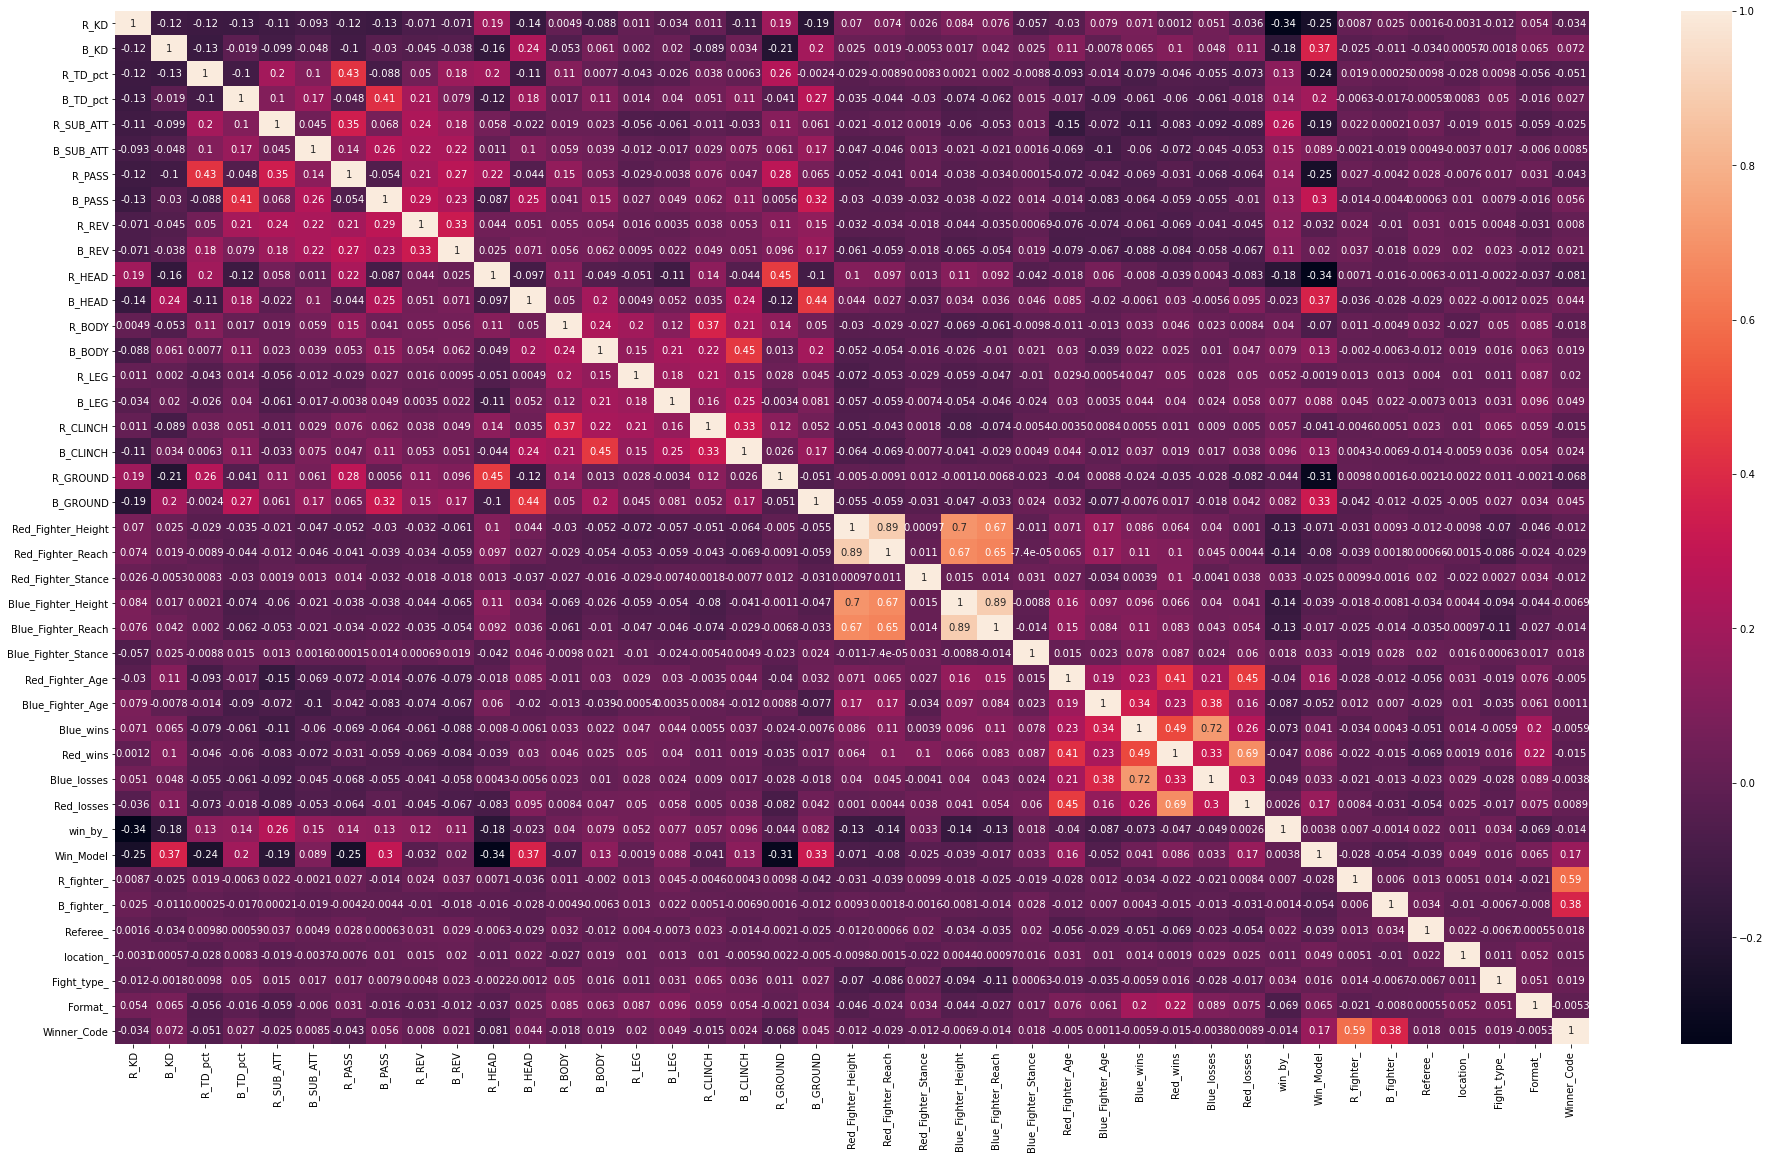

In [36]:
### Gráfico de correlacao
plt.figure(figsize=(33,19))

corr = df_combats_model.corr()
sn.heatmap(corr, annot=True)

plt.show()

In [37]:
df_combats_model.shape

(4643, 41)

## ML - Modelo de classificação

O Modelo estatístico aqui aplicado será o modelo de classificação supervisionado, pois a reposta esperada é categórica, indicando qual dos corners irá vencer o combate a partir dos dados coletados neste trabalho.

### Divisão do dataset e padronização da semente

Nesta primeira etapa realizei a padronização da semente do modelo, para obter um resultado que pode ser reexecutado e fiz a separação do dataset de treino e de teste.

In [45]:
SEED = 0
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))

#semente   
random_state = 1

X = df_combats_model
y = df_combats_model['Win_Model']

X = X.drop(['Win_Model'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

### Regressão Logística

Técnica estatistica que por meio de análise das observações permite a predição de um valor resposta (target) categórico, que é o caso que escolhi neste trabalho, a resposta esperada é a indicação de qual corner irá vencer a luta com base nos dados coletados que foram processados neste trabalho.

In [40]:
log = LogisticRegression(solver='liblinear')
log.fit(X_train, y_train)
log_y_val_pred = log.predict(X_test)

results = cross_val_score(log, X_train, y_train, cv = cv, 
                          scoring = 'precision')
intervalo_prec(results)

Precisão média: 80.23%
Intervalo de Precisão: [77.24% ~ 83.23%]


### Arvore de classificação

É uma técnica que visa identificar grupos em comum entre as covariáveis, utiliza de um método recursivo que realiza a divisão da amostra em subamostras se baseando na relação dessas variáveis. O intuito é criar grupos onde a variável resposta (target) mostram aspectos homogêneo dentro do grupo e heterogêneo entre eles.

In [41]:
dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(X_train, y_train)
dtc_y_val_pred = dtc.predict(X_test)

results = cross_val_score(dtc, X_train, y_train, cv = cv, 
                          scoring = 'precision')
intervalo_prec(results)

Precisão média: 81.75%
Intervalo de Precisão: [63.21% ~ 100.29%]


### Support Vector Machines

O modelo de Máquina de Vetores de Suporte (SVM, do inglês: *Support Vector Machine*) é um modelo de classificação binário supervisionado, que avalia os dados e reconhecem padrões entre as covariáveis e a variável resposta, busca o hiperplano entre os dados e duas classes.

In [42]:
##SVC
svc = SVC(random_state=random_state)
svc.fit(X_train, y_train)
svc_y_val_pred = svc.predict(X_test)

results = cross_val_score(svc, X_train, y_train, cv = cv, 
                          scoring = 'precision')
intervalo_prec(results)

Precisão média: 100.00%
Intervalo de Precisão: [100.00% ~ 100.00%]


### Random Forest

O modelo Floresta Aleatória (Random Forest em inglês) é um algoritmo de aprendizagem supervisionada. Sua caracteristica é a criação de uma árvore de decisão de um modo aleatório, o modelo utiliza de técnicas de *ensemple* e *bagging* para potencializar o resultado do modelo.

In [43]:
# Randon Forest
rf1 = RandomForestClassifier(random_state=random_state)
rf1.fit(X_train, y_train)
rf1_y_val_pred = rf1.predict(X_test)

results = cross_val_score(rf1, X_train, y_train, cv = cv, 
                          scoring = 'precision')
intervalo_prec(results)

Precisão média: 89.24%
Intervalo de Precisão: [83.99% ~ 94.50%]


### Resultados

Os resultados obtidos são apresentados abaixo, onde o melhor resultado para este dataset foi o modelo **Random Forest**, embora o modelo SVM tenha uma precisão 100% o seu modelo parece enviesado, pois pela matriz de confusão podemos validar que o modelo está apresentando uma alta tendência a vitórias para o corner vermelho, considerando a métricas de acurária, R² ajustado e a métrica de ROC (Receiver Operating Characteristic) são menores comparados ao modelo *Random Forest*, porém a área abaixo da curva (AUC) de ambas são iguais: 0,96. A métrica de ROC do modelo Random Forest apresentou um valor de 0,84 sendo a melhor resultado dentre os modelos testados.

================= Regressão Logística ===================

ACURÁCIA:                 0.7933
PRECISÃO:                 0.7866
F1-SCORE:                 0.6104
ERRO QUADRADO AJUSTADO:   0.3146
ROC SCORE:                0.7168
MATRIZ DE CONFUSÃO:      
 [[733  51]
 [189 188]]
=================== Arvore de decisao ===================

ACURÁCIA:                 0.7933
PRECISÃO:                 0.7866
F1-SCORE:                 0.6104
ERRO QUADRADO AJUSTADO:   0.3146
ROC SCORE:                0.7168
MATRIZ DE CONFUSÃO:      
 [[733  51]
 [189 188]]
=====================      SVN      =====================

ACURÁCIA:                 0.8734
PRECISÃO:                 1.0
F1-SCORE:                 0.7578
ERRO QUADRADO AJUSTADO:   0.5367
ROC SCORE:                0.805
MATRIZ DE CONFUSÃO:      
 [[784   0]
 [147 230]]
===================== Random Forest =====================

ACURÁCIA:                 0.8854
PRECISÃO:                 0.9207
F1-SCORE:                 0.8006
ERRO QUADRADO AJUSTADO: 

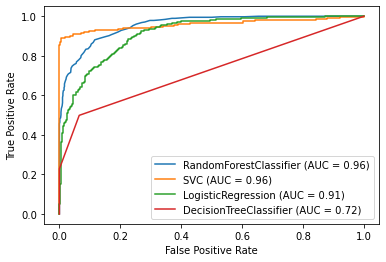

In [44]:
print('================= Regressão Logística ===================\n')
model_performance(log, X_test, y_test, dtc_y_val_pred)
print('=================== Arvore de decisao ===================\n')
model_performance(dtc, X_test, y_test, dtc_y_val_pred)
print('=====================      SVM      =====================\n')
model_performance(svc, X_test, y_test, svc_y_val_pred)
print('===================== Random Forest =====================\n')
model_performance(rf1, X_test, y_test, rf1_y_val_pred)

print('\n\n**********************      ROC      **********************\n\n')
ax = plt.gca()

resp = metrics.plot_roc_curve(rf1, X_test, y_test, ax=ax)
resp = metrics.plot_roc_curve(svc, X_test, y_test, ax=ax)
resp = metrics.plot_roc_curve(log, X_test, y_test, ax=ax)
resp = metrics.plot_roc_curve(dtc, X_test, y_test, ax=ax)
plt.show()